# CSCE 5214 Project 1

*View README.md to get started.

Developed by Matthew Bolding.

In [1]:
import pandas as pd

# Loading the dataset...
df = pd.read_csv('data/credit_card_fraud.csv')

In [2]:
'''
Below are all the columns included in the CSV file. Not all columns will be kept;
some columns provide essentially zero information, such as hashed card numbers and
CVV codes. We may remove these even before visualizations.

'Transaction Date and Time'
    We will include this variable and use its values to determine the transaction's 
    hour and day of the week it occurred. We will also include the year so that the
    model will have knowledge of the transaction's year and card's expiry date.

    Variables from this column will be numeric.
    
'Transaction Amount'
    We will include this variable. Numeric.
    
'Cardholder Name'
    We will exclude this variable.
    
'Card Number (Hashed or Encrypted)'
    We will exclude this variable.
    
'Merchant Name'
    We will exclude this variable.
    
'Merchant Category Code (MCC)'
    We will include this variable. Categorical.
    
'Transaction Location (City or ZIP Code)'
    We will include this variable. Categorical.
    
'Transaction Currency'
    We will include this variable. Categorical.
    
'Card Type'
    We will include this variable. Categorical.
    
'Card Expiration Date'
    We will include this variable as the numeric year and month.
    
'CVV Code (Hashed or Encrypted)'
    We will exclude this variable.
    
'Transaction Response Code'
    We will include this variable. Categorical.
    
'Transaction ID'
    We will exclude this variable.
    
'Fraud Flag or Label'
    This is our outcome variable. Categorical.
    
'Previous Transactions'
    We will include this variable. Numeric. We will have to properly encode this
    variable since the given values are either None, 1, 2, or 3 or more. We will 
    encode this as 0, 1, 2, or 3, numerically.
    
'Transaction Source'
    We will include this variable. Categorical.
    
'IP Address'
    We will include this variable. Categorical.
    
'Device Information'
    We will include this variable. Categorical.
    
'User Account Information'
    We will exclude this variable.
    
'Transaction Notes'
    We will exclude this variable.
'''

# Removing unneeded predictor variables...
drop_cols = [
    'Cardholder Name',
    'Card Number (Hashed or Encrypted)',
    'Merchant Name',
    'CVV Code (Hashed or Encrypted)',
    'Transaction ID',
    'User Account Information',
    'Transaction Notes'
]

df.drop(columns=drop_cols, inplace=True)

# We also drop any row that includes NaN values.
df.dropna(inplace=True)

In [3]:
# Before performing visualizing, we must clean our data some.
df['Transaction Date and Time'] = pd.to_datetime(df['Transaction Date and Time'], errors='coerce')
df['Transaction Hour'] = df['Transaction Date and Time'].dt.hour
df['Transaction Day'] = df['Transaction Date and Time'].dt.dayofweek
df['Transaction Year'] = df['Transaction Date and Time'].dt.year

df['Fraud Flag or Label'] = df['Fraud Flag or Label'].astype(int)

df['Previous Transactions'] = df['Previous Transactions'].map({
    'None': 0,
    '1': 1,
    '2': 2,
    '3 or more': 3
})

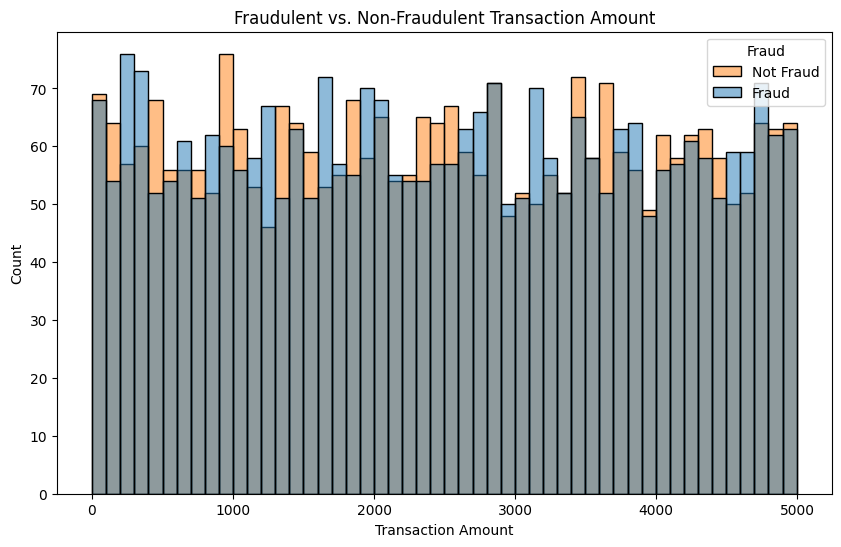

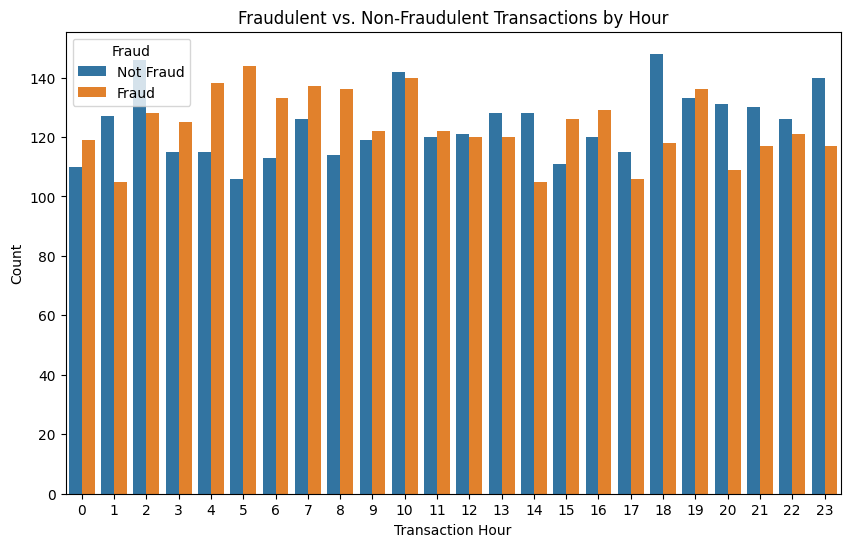

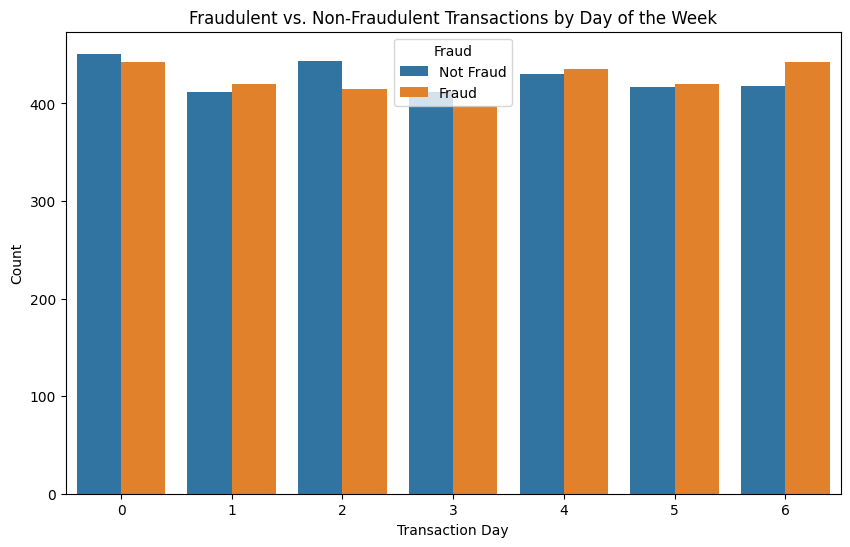

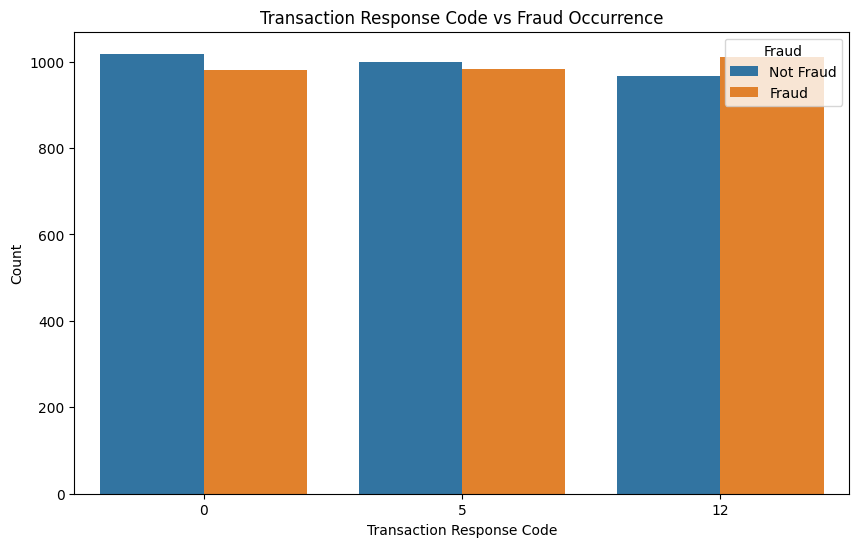

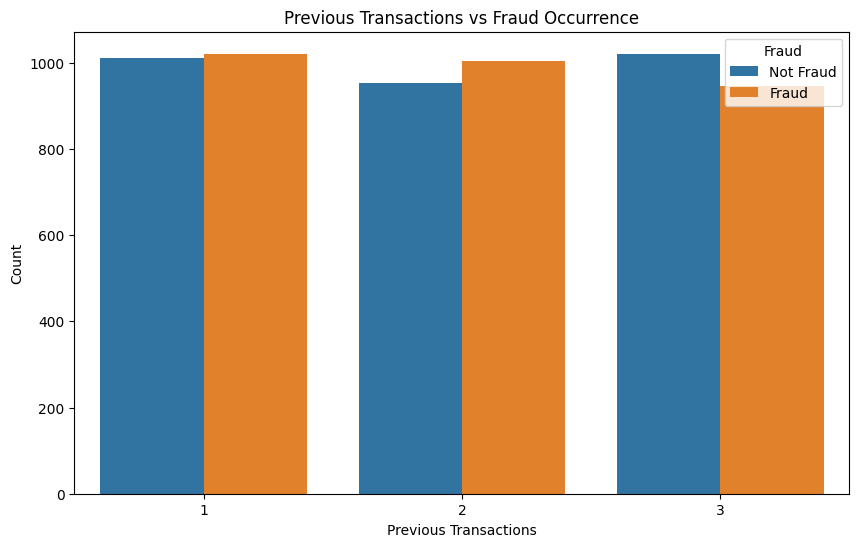

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

'''
We may want to visualize a variety of potentially important predictor variables from our
dataset. We will perform these visualizations with seaborn.
'''

# Viewing the transaction amount distribution...
plt.figure(figsize=(10, 6))
sns.histplot(x='Transaction Amount', bins=50, hue='Fraud Flag or Label', data=df)
plt.title("Fraudulent vs. Non-Fraudulent Transaction Amount")
plt.ylabel('Count')
plt.legend(title='Fraud', labels=['Not Fraud', 'Fraud'])
plt.show()

# Does the hour of the day matter for determining fraudulent transactions?
plt.figure(figsize=(10, 6))
sns.countplot(x='Transaction Hour', hue='Fraud Flag or Label', data=df)
plt.title("Fraudulent vs. Non-Fraudulent Transactions by Hour")
plt.ylabel('Count')
plt.legend(title='Fraud', labels=['Not Fraud', 'Fraud'])
plt.show()

# What about day of the week?
plt.figure(figsize=(10, 6))
sns.countplot(x='Transaction Day', hue='Fraud Flag or Label', data=df)
plt.title("Fraudulent vs. Non-Fraudulent Transactions by Day of the Week")
plt.ylabel('Count')
plt.legend(title='Fraud', labels=['Not Fraud', 'Fraud'])
plt.show()

# Maybe response code could tell us something.
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Transaction Response Code', hue='Fraud Flag or Label')
plt.xlabel('Transaction Response Code')
plt.ylabel('Count')
plt.title('Transaction Response Code vs Fraud Occurrence')
plt.legend(title='Fraud', labels=['Not Fraud', 'Fraud'])
plt.show()

# or possibly how many previous transactions affect a transaction's validity.
# Maybe response code could tell us something.
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Previous Transactions', hue='Fraud Flag or Label')
plt.xlabel('Previous Transactions')
plt.ylabel('Count')
plt.title('Previous Transactions vs Fraud Occurrence')
plt.legend(title='Fraud', labels=['Not Fraud', 'Fraud'])
plt.show()

In [5]:
import re
from sklearn.preprocessing import StandardScaler, OneHotEncoder

'''
Now that we've visualized some of the data, we can proceeed with the remainder of data preprocessing.

It's worth noting that the graphs above do not present an easy method of predicting a fraudulent
transaction. (For instance, if we were to see exclusively fraudulent transactions during the 2 AM hour,
we could possibly begin to make some conclusions, but no such patters overtly exist.
'''

categorical_cols = [
    'Merchant Category Code (MCC)',
    'Transaction Location (City or ZIP Code)',
    'Transaction Currency',
    'Card Type',
    'Transaction Response Code',
    'Transaction Source',
    'IP Address',
    'Device Information'
]

# We define a function to extract the expiry date of the card.
def extract_expiry_date(exp_date):
    parts = re.split(r'[/]', exp_date)
    month, year = int(parts[0]), int(parts[1]) + 2000
    return month, year

df[['Expiration Month', 'Expiration Year']] = df['Card Expiration Date'].apply(lambda x: pd.Series(extract_expiry_date(x)))

numerical_cols = [
    'Transaction Amount',
    'Transaction Hour',
    'Transaction Day',
    'Transaction Year',
    'Expiration Month',
    'Expiration Year'
]

# Encode categorical variables...
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_categorical = encoder.fit_transform(df[categorical_cols])

# Standardize numerical features...
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(df[numerical_cols])

In [6]:
import numpy as np

# We may now create the unified dataset.
X = np.hstack((scaled_numerical, encoded_categorical))
y = df['Fraud Flag or Label'].values

In [7]:
import torch
from sklearn.model_selection import train_test_split

# Split the dataset...
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape for BCELoss
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [8]:
from torch.utils.data import DataLoader, TensorDataset

# Setting a batch size...
# This may not be strictly necessary for this dataset, but we'll still use it.
batch_size = 64

# Creating the datasets...
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Creating the DataLoaders from the Datasets. The loaders handle the
# management and iteration over batches.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
import torch.nn as nn
import torch.optim as optim

# Define the Neural Network
class FraudDetectionNN(nn.Module):
    def __init__(self, input_dim):
        super(FraudDetectionNN, self).__init__()
        # Defining the hidden layers in the neural network
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)

        # Defining two types of activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # Defining a dropout mechanism to assist the model's learning ability
        self.dropout = nn.Dropout(0.3)
    
    # Manually implemented forward propagation
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc4(x))
        return x

In [10]:
# Setting up the training loop...
# Create an instance of the model...
input_dim = X_train.shape[1]
model = FraudDetectionNN(input_dim)

# Configure the optimizer...
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0125, momentum=0.9)

# Enter the training loop...
epochs = 200
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Nested for loop
    for inputs, labels in train_loader:
        # Reset gradients...
        optimizer.zero_grad()
        
        # Forward propagation...
        outputs = model(inputs)

        # Calculate the loss...
        loss = criterion(outputs, labels)

        # Backpropagation...
        loss.backward()

        # Updating the weights...
        optimizer.step()

        # Adding the loss of this batch to the epoch's loss...
        running_loss += loss.item()

    if epoch % 10 == 0: print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/200, Loss: 0.6943
Epoch 11/200, Loss: 0.6930
Epoch 21/200, Loss: 0.6922
Epoch 31/200, Loss: 0.6888
Epoch 41/200, Loss: 0.6386
Epoch 51/200, Loss: 0.4568
Epoch 61/200, Loss: 0.2838
Epoch 71/200, Loss: 0.2006
Epoch 81/200, Loss: 0.0799
Epoch 91/200, Loss: 0.0599
Epoch 101/200, Loss: 0.0404
Epoch 111/200, Loss: 0.0424
Epoch 121/200, Loss: 0.0273
Epoch 131/200, Loss: 0.0284
Epoch 141/200, Loss: 0.0103
Epoch 151/200, Loss: 0.0116
Epoch 161/200, Loss: 0.0141
Epoch 171/200, Loss: 0.0249
Epoch 181/200, Loss: 0.0064
Epoch 191/200, Loss: 0.0143


In [11]:
# Evaluating the model...
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

    # Final layer in neural network is sigmoid, so output will be float in interval (0, 1)...
    y_pred = (y_pred > 0.5).astype(int)

accuracy = np.mean(y_pred.flatten() == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

'''
The final accuracy of the model is not great---it's around 0.5. Such an accuracy means that the model
is effectively no better than blindly guessing as to whether a transaction is fraudulent. I had expected
the model to perform with some sort of predictive accuracy, but this was not the case.

I believe the issue is rooted in at least one of a few potential issues.
    1. A bad model architecture. It's possible that a simple feed forward model
    isn't complex enough to capture the intricacies of fraud detection.
    
    2. Incorrectly scaling variables in the preprocessing phase.
    
    3. Leaving out important predictor variables in the preprocessing phase. I
    excluded the ones I did based on my gut feeling and not on a statistical
    finding
'''

Test Accuracy: 0.5089


"\nThe final accuracy of the model is not great---it's around 0.5. Such an accuracy means that the model\nis effectively no better than blindly guessing as to whether a transaction is fraudulent. I had expected\nthe model to perform with some sort of predictive accuracy, but this was not the case.\n\nI believe the issue is rooted in at least one of a few potential issues.\n    1. A bad model architecture. It's possible that a simple feed forward model\n    isn't complex enough to capture the intricacies of fraud detection.\n    \n    2. Incorrectly scaling variables in the preprocessing phase.\n    \n    3. Leaving out important predictor variables in the preprocessing phase. I\n    excluded the ones I did based on my gut feeling and not on a statistical\n    finding\n"